# The time-frequency tradeoff in signal processing
While physics may be famous for its "uncertainty principle", the world of signal processing has a very similar rule at its core. Often called the "time-frequency tradeoff", this idea states that the more we understand how a signal changes in time, the less detail we have about its frequency makeup.

To illustrate this, I'm going to use two of my favorite new tools - Jupyter widgets and Binder. We'll play around with a time-varying signal (a recording of my voice), and see how the time-frequency tradeoff works.

First, we'll load some data

In [47]:
# For loading and processing data
import matplotlib.pyplot as plt
import mne
import numpy as np
from scipy.io import wavfile

# For making nifty widgets
from IPython.display import display
from ipywidgets import interact, widgets
%matplotlib inline

In [69]:
# Here's a wavfile of me speaking
fs, data = wavfile.read('../data/science_is_awesome.wav')
times = np.arange(data.shape[0]) / float(fs)

Let's look at a quick plot of the data. 

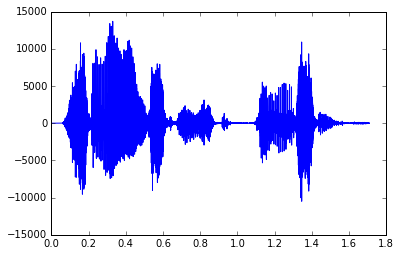

In [106]:
f, ax = plt.subplots()
ax.plot(times, data)
_ = axs[0].set_title('The raw signal', fontsize=20)

As we can see, it is a single, time-varying signal. This represents the changing air pressure that occurs as a result of my vocal chords vibrating. There's clearly something going on, but its' a bit hard to decipher.

However, we have years of research in auditory processing on our side, and so we know that underneath this 1-D signal is a much more complicated story in frequency space.

To show this, I'll plot the raw signal, as well as a spectrogram of the signal:

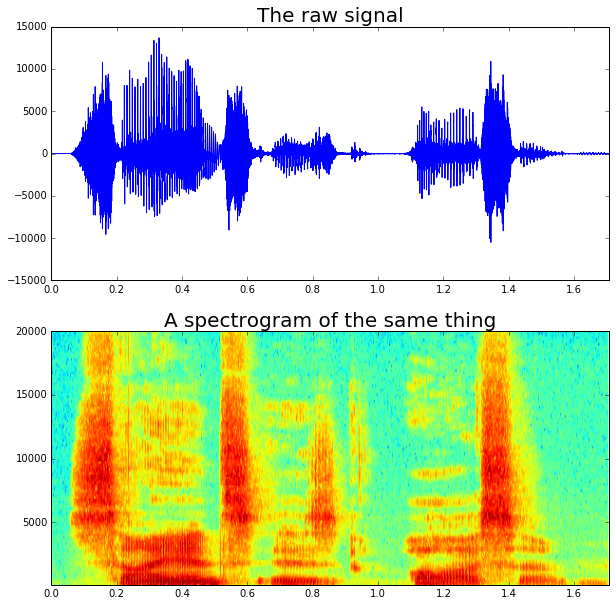

In [109]:
f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].plot(times, data)
_ = axs[0].set_title('The raw signal', fontsize=20)
_ = axs[1].specgram(data, Fs=fs)
_ = axs[1].set_title('A spectrogram of the same thing', fontsize=20)
_ = plt.setp(axs, xlim=[times.min(), times.max()])
_ = plt.setp(axs[1], ylim=[freqs.min(), freqs.max()])

The spectrogram attempts to do the following things:

1. Break down our 1-D signal into a bunch of sine waves, moving from low-frequency to high-frequency
1. Create a **window** around a subset of time in the 1-D signal. Report how much each sine wave is "contributing" to the signal within that window. E.g., if the signal is changing very slowly, it will result in hot colors near the bottom of the plot (the lower frequencies).
1. Now do the same thing for another window a little bit later. The second window might be **overlapping** with the first window by some amount.
1. Continue this process until we have stepped through the entire original signal. Each window gives us a column of the spectrogram, and when we stitch them all together, we get the nice plot above

This is often called a **time-frequency decomposition**. This means that we have taken a single time-varying signal, and decomposed it into a bunch of time-varying frequency bands.

## Now on to time-frequency tradeoffs
As you may have noticed, there are two things that are particularly easy to vary when you calculate the spectrogram. One is the **window size**, and the other is the **amount of overlap** between two windows. These are parameters that we can pass to the spectrogram function, and they allow us to control the time-frequency tradeoff of our plot.

As an example, I'll show the same plot above, but now with a couple sliders that let you play around with the window size, and the window overlap. See what happens when you drag the window size to be larger and larger, as well as smaller and smaller.

The parameter **n_fft** controls how large the window is. The spectrogram function calculates the frequency content in each window using something called a Fast Fourier Transform. **n_fft** controls how many points are used in the FFT, AKA how large the window is.

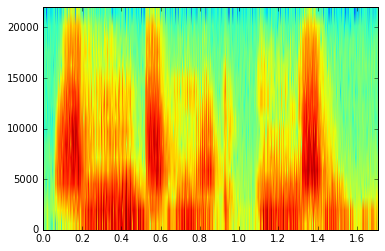

In [108]:
f, ax = plt.subplots(figsize=(10, 5))

nfft_widget = widgets.IntSlider(min=3, max=15, step=1, value=10)
n_overlap_widget = widgets.IntSlider(min=3, max=15, step=1, value=9)

def update_n_overlap(*args):
    n_overlap_widget.value = np.clip(n_overlap_widget.value, None, nfft_widget.value-1)
nfft_widget.observe(update_n_overlap, 'value')
n_overlap_widget.observe(update_n_overlap, 'value')

def func(n_fft, n_overlap):
    spec, freqs, spec_times, _ = ax.specgram(data, Fs=fs,
                                        NFFT=2**n_fft, noverlap=2**n_overlap,
                                        animated=True)
    ax.set(xlim=[spec_times.min(), spec_times.max()],
           ylim=[freqs.min(), freqs.max()])
    plt.close(f)
    display(f)
w = interact(func, n_fft=nfft_widget,
             n_overlap=n_overlap_widget)

In this case, the window size (n_fft) is the biggest factor in determining our frequency / time tradeoff. If you use really large windows, then you lose time detail. If you use really small windows, then you lose frequency detail. This is the time-frequency tradeoff in action.

# Other time-frequency methods
There are lots of other methods out there for doing time-frequency decompositions, and many of them exist to try and work out a better balance between time and frequency resolution. One really popular method uses little window functions called "morlet wavelets". This is similar to the windows that we used above, but with a more complicated window.

With wavelets, we can define an arbitrary set of frequency bands to include in the time-frequency decomposition. We can also define the **number of cycles** to keep in each wavelet. We'll create a wavelet for each frequency band, and the number of cycles will determine how long it is.

If we keep the number of cycles fixed at 5. Wavelets with a lower frequency will naturally be longer, while wavelets with smaller frequency will be shorter. This is because lower frequencies vary over longer stretches of time, so completing 5 cycles takes a while.

In this way, we're trying to tune the size of the window to the frequency band. We're basically saying "frequencies that vary over long periods of time should have a longer window" (and vice versa).

We can play around with this effect in the same way as above. Below, we'll plot the **continuous wavelet transform** using Morlet wavelets. You can play around both with the number of frequencies used in this transform, as well as the number of cycles in each wavelet. See how this affects the time-frequency tradeoff.

(note that we are now showing the y-axis on a log scale, to account for the fact that in general, we care more about frequency resolution at lower frequencies, and time resolution at higher frequencies)

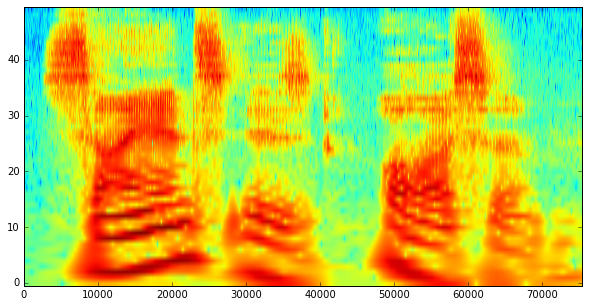

In [111]:
# Note that now the sliders won't update until you release the mouse to save time.
f, ax = plt.subplots(figsize=(10, 5))
def func(n_cycles, n_freqs):
    plt.close(f)
    freqs = np.logspace(np.log10(100), np.log10(20000), n_freqs)
    amps = mne.time_frequency.cwt_morlet(data[np.newaxis, :], fs,
                                         freqs, n_cycles=n_cycles)
    amps = np.log(np.abs(amps))[0]
    ax.imshow(amps, animated=True, origin='lower', aspect='auto')
    display(f)
    
n_cycles_widget = widgets.IntSlider(min=5, max=50, step=1, value=3, continuous_update=False)
n_freqs_widget = widgets.IntSlider(min=10, max=150, step=10, value=50, continuous_update=False)
w = interact(func, n_cycles=n_cycles_widget, n_freqs=n_freqs_widget)

As you can see above, changing the cycles and number of frequencies in the wavelets also tends to smear the plot along either the time dimension (x-axis) or frequency dimension (y-axis). You might have also noticed that it doesn't smear things quite as bad as the `specgram` function above. That's because the wavelet transform tends to do a better job at balancing time-frequency resolution than the FFT.

## Wrap up
There are lots of methods out there for doing time-frequency decompositions, but they all have to deal with the same fundamental tradeoff of time vs. frequency. The details of each algorithm will determine how elegantly they handle this, and some are more well-suited to accentuate one component of your signal over another.

If you want to learn more about the time-frequency tradeoff, check out the following links:

1. [Here's a good stackoverflow question on this topic](http://stackoverflow.com/questions/5887366/matlab-spectrogram-params) (though note that it uses Matlab instead of python)
1. Here are wikipedia pages on [window functions](https://en.wikipedia.org/wiki/Window_function) and [spectral leakage](https://en.wikipedia.org/wiki/Spectral_leakage)